# Solutions: Polygon data

In [1]:
# import modules
import geopandas as gpd
import folium
import json
import branca

## Polygon data formats

In this tutorial we will work with a shapefile of *polygons* representing municipalities in the provinces of Utrecht and Noord-Holland. 

In [2]:
df = gpd.read_file('Data/polygon/Utrecht_NoordHolland.shp', geometry='geometry')

In [3]:
df.head()

mzr_id             mzr_name  wnp_id        wnp_name  gem_id  \
0    7142  Wieringerwaard e.o.    3187  Wieringerwaard    1911   
1    7108      Nibbixwoud e.o.    3153      Nibbixwoud     420   
2    7103        Abbekerk e.o.    3147        Abbekerk     420   
3    7065            Purmerend    3103       Purmerend     439   
4    7472             Overveen    2653        Overveen     377   

         gem_name  prov_id      prov_name  inhabitant  address_co  NEAR_FID  \
0  Hollands Kroon       27  Noord-Holland      8020.0      3566.0     19990   
1       Medemblik       27  Noord-Holland      4865.0      2340.0     15468   
2       Medemblik       27  Noord-Holland      3985.0      1851.0     15389   
3       Purmerend       27  Noord-Holland     79610.0     39860.0     14461   
4     Bloemendaal       27  Noord-Holland      4170.0      1785.0     61524   

     NEAR_DIST                                           geometry  
0  4006.929967  POLYGON ((120246.500 527259.100, 120274.000 52...  
1   147.141043  POLYGON ((138590.100 523244.100, 137428.700 52...  
2     0.000000  POLYGON ((132527.800 525385.900, 132537.400 52...  
3     0.000000  POLYGON ((126892.300 498152.100, 126836.600 49...  
4  2999.323658  POLYGON ((101658.600 488853.900, 101654.400 48...

Provinces are identified by the "prov_name" column. The different municipalities are identified by "gem_name" (gem stands for gemeente in Dutch). Municipalities can be further subdivided in multiple connected small cities and villages. The "inhabitant" column identifies the number of people living in each subdivision according to census. For instance, the gemeente of *Amsterdam* is made of 8 densely populated parts.

In [4]:
# show number of subdivision in each gemeente
df['gem_name'].value_counts()

Hollands Kroon    8
Haarlemmermeer    8
Amsterdam         8
Schagen           7
Zaanstad          7
                 ..
Veenendaal        1
Renswoude         1
Lopik             1
Oostzaan          1
Woudenberg        1
Name: gem_name, Length: 74, dtype: int64

In [5]:
df.sort_values(by='inhabitant', ascending=False).head()

mzr_id              mzr_name  wnp_id   wnp_name  gem_id   gem_name  \
61     7516  Amsterdam Nieuw-West    3594  Amsterdam     363  Amsterdam   
65     7513        Amsterdam Zuid    3594  Amsterdam     363  Amsterdam   
143    7512        Amsterdam West    3594  Amsterdam     363  Amsterdam   
64     7514        Amsterdam Oost    3594  Amsterdam     363  Amsterdam   
62     7515       Amsterdam Noord    3594  Amsterdam     363  Amsterdam   

     prov_id      prov_name  inhabitant  address_co  NEAR_FID  NEAR_DIST  \
61        27  Noord-Holland    149450.0     72496.0      9382        0.0   
65        27  Noord-Holland    136200.0     85469.0      9481        0.0   
143       27  Noord-Holland    132200.0     77902.0     61346        0.0   
64        27  Noord-Holland    128655.0     72229.0       436        0.0   
62        27  Noord-Holland     91275.0     47607.0     18742        0.0   

                                              geometry  
61   POLYGON ((118127.700 483140.700, 117663.800 48...  
65   POLYGON ((116411.200 482117.600, 116307.400 48...  
143  POLYGON ((118582.700 484940.700, 118576.800 48...  
64   POLYGON ((128038.400 486063.200, 128297.300 48...  
62   POLYGON ((129812.200 488550.500, 129530.700 48...

Similar to what we saw for Points and LineStrings, a basic plot of each polygon can be obtained in the following fashion

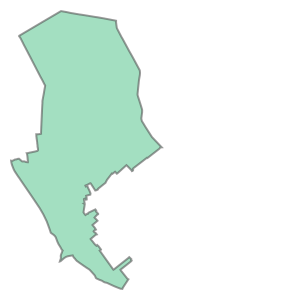

In [6]:
df.geometry[0]

The `exterior` attribute contains geometrical information concerning the boundary of the polygon

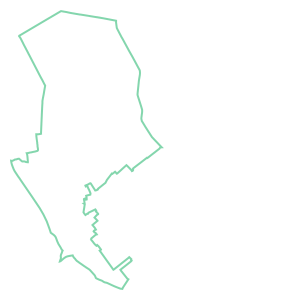

In [7]:
df.geometry[0].exterior

The `area` attribute reports the area within the perimeter. A quick comparison for the [city of Utrecht](https://en.wikipedia.org/wiki/Utrecht) suggests these are pretty accurate.

In [8]:
# divide by 1000x1000 to have the value in sq. km

df[df['gem_name']=='Utrecht'].area.sum()/10**6

99.21472385001576

## Polygon data visualization

While not extremely sophisticated, `geopandas` offers some interesting plotting functionalities for polygons. Here is for instance a quick color-coded plot for the number of inhabitants within each polygon.

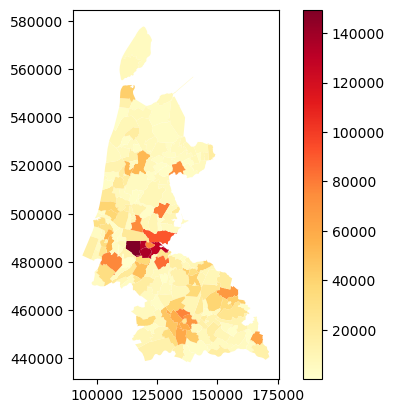

In [9]:
df.plot(column = 'inhabitant', cmap='YlOrRd', legend=True);

We resort to `folium` for better visualization. First, we transform our coordinate system to the standard "EPSG:4326" used by the library. We then plot a base map centered average latitude/longitude coordinates of the gemeente of Utrecht. After that, we plot all the polygons for this gemeente along with some informative pop-up windows.

In [10]:
df.to_crs(epsg=4326, inplace=True)

In [11]:
# select Utrecht rows
utrecht_sel = df['gem_name']=='Utrecht'

# compute average coordinates
avg_x_coord = (df[utrecht_sel].bounds.minx+df[utrecht_sel].bounds.maxx)/2
avg_y_coord = (df[utrecht_sel].bounds.miny+df[utrecht_sel].bounds.maxy)/2

In [12]:
# create folium base map
poly_map = folium.Map(
    location=[avg_y_coord.mean(),avg_x_coord.mean()],    
    zoom_start=12
)

# visualize Utrecht polygons
utrecht_gjson = folium.features.GeoJson(
    df[utrecht_sel],
).add_to(poly_map)

# add informative pop-up windows
folium.features.GeoJsonPopup(
    fields=['mzr_name', 'gem_name', 'inhabitant'],
    aliases=['Location', 'Municipality', 'Population'],
    labels=True
).add_to(utrecht_gjson)

# visualize map
poly_map

### Tooltip

Clicking on each displayed element to retrieve information can be tedious; `folium` offers an interesting alternative with the `Tooltip` feature. By using `Tooltip` we can easily show information when hovering the mouse pointer on each polygon.

In [13]:
# create folium base map
poly_map = folium.Map(
    location=[avg_y_coord.mean(),avg_x_coord.mean()],    
    zoom_start=12
)

# visualize Utrecht polygons
utrecht_gjson = folium.features.GeoJson(
    df[utrecht_sel],
).add_to(poly_map)

# add tooltip functionality
folium.features.GeoJsonTooltip(
    fields=['mzr_name', 'gem_name', 'inhabitant'],
    aliases=['Location', 'Municipality', 'Population']
).add_to(utrecht_gjson)

# visualize map
poly_map

### Choropleth

While prettier, the maps above are somewhat less informative than the `geopandas` visualization on the distribution of inhabitants across the municipalities. 

These type of maps are known as [choropleth map](https://en.wikipedia.org/wiki/Choropleth_map). Choropleth maps are statistical thematic maps that use color coding to provide aggregate summary of a geographic characteristic within spatial enumeration units, such as totals (e.g. total population) or averages (e.g. population density or per-capita income). Choropleth maps provide an easy way to visualize how a variable varies across a geographic area or show the level of variability within a region.

[There are many ways](https://towardsdatascience.com/creating-choropleth-maps-with-pythons-folium-library-cfacfb40f56a) to create such visualizations with `folium`. Below we provide a solution that exploits `style_functions` and the `branca` library as introduced in the [previous notebook](./2_Lines.ipynb) on `LineStrings`.

In [76]:
# create learn colormap interpolating 3 colors
colors = branca.colormap.LinearColormap(
    ['green', 'yellow', 'red'], vmin=df.inhabitant.min(), vmax=df.inhabitant.max())

In [77]:
# define style function
def population_choropleth(row):
    return {
        "fillColor": colors(row['properties']['inhabitant']),
        "color": "white",
        "weight": 1,
        "fillOpacity": 0.75,
    }

In [78]:
# create base map
poly_map = folium.Map(
    location=[avg_y_coord.mean(),avg_x_coord.mean()],    
    zoom_start=8
)

# overlay choropleth
gjson = folium.features.GeoJson(
    df,
    style_function=population_choropleth,
    ).add_to(poly_map)

# add colormap to the map
poly_map.add_child(colors)

# display
poly_map

### Exercise

You are given a geospatial dataset for the provinces in Vietnam. The dataset contains the polygon geometry along with information on the name of the province, whether it is a city or not, and its surface area in sq. km. 

In [103]:
gdf_vietnam = gpd.read_file('./Data/case_study/vietnam_bound.geojson')
gdf_vietnam['area_sqkm']=round(gdf_vietnam.to_crs(epsg=9215).area/10**6)
gdf_vietnam = gdf_vietnam[['VARNAME_1','ENGTYPE_1','area_sqkm','geometry']]
gdf_vietnam.columns = ['name','type','area_sqkm','geometry']

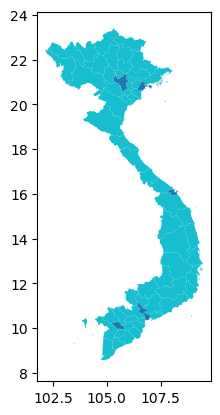

In [105]:
gdf_vietnam.plot(column='type');

Your task is to use `folium` as shown earlier in the notebook to display a Cloropeth map for the Vietnam provinces, where:

1. The map is centered on Hanoi, e.g. `latitude = 21.03 N`, `longitude = 105.8 E`;
2. The Cloropeth shows the surface area of each province; 
3. Colors are assigned using a linear `branca` colormap scaled between the minimum and the maximum;
4. The colorbar is visible on the map;
5. The map has a `Tooltip` feature that shows all information available on the province.

#### Solution

In [106]:
# create colormap
colors = branca.colormap.LinearColormap(['gray','blue','purple'], 
                                         vmin=gdf_vietnam['area_sqkm'].min(), vmax=gdf_vietnam['area_sqkm'].max())

# define style function
def area_choropleth(row):
    return {
        "fillColor": colors(row['properties']['area_sqkm']),
        "color": "white",
        "weight": 1,
        "fillOpacity": 0.75,
    }

# create base map
vtn_map = folium.Map(
    location=[21.03, 105.8],
    zoom_start=5
)

# overlay choropleth
vtn_gjson = folium.features.GeoJson(
    gdf_vietnam,
    style_function=area_choropleth,
    ).add_to(vtn_map)

# add tooltip functionality
folium.features.GeoJsonTooltip(
    fields=['name','type','area_sqkm']
).add_to(vtn_gjson)

# add colormap to the map
vtn_map.add_child(colors)

# display
vtn_map